<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup 

If marked as `code`, the two following cells will 

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from problem import get_train_data, get_test_data
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

The Data

In [4]:

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [5]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### A first look at the data


In [6]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

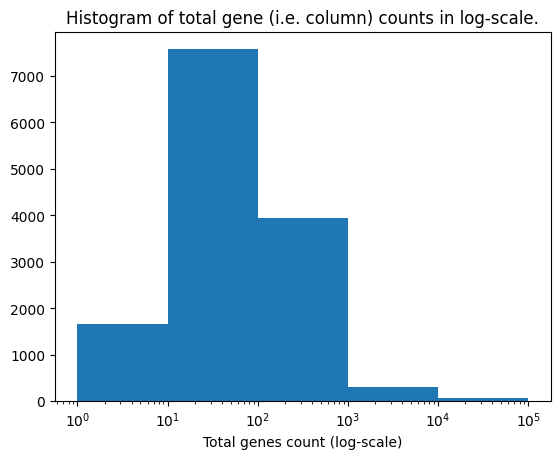

In [7]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

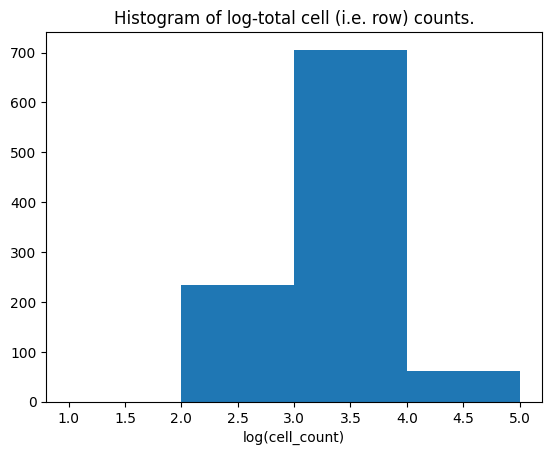

In [8]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

In [9]:
# Convert to DataFrame
x_train = pd.DataFrame(X_train.toarray())
x_test = pd.DataFrame(X_test.toarray())
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,13541,13542,13543,13544,13545,13546,13547,13548,13549,13550
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
classes = y_train.categories
print(classes)
annotation ={} 
for i, cls in enumerate(classes):
    annotation[i] = cls
print(annotation)

Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object')
{0: 'Cancer_cells', 1: 'NK_cells', 2: 'T_cells_CD4+', 3: 'T_cells_CD8+'}


0. Cancer_cells
1. NK_cells
2. T_cells_CD4+
3. T_cells_CD8+


In [11]:
# Annotation des classes
y_train_encoded = y_train.codes
y_test_encoded = y_test.codes
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

y_train.head()

0    2
1    2
2    2
3    2
4    3
dtype: int8

{'classes': Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object'), 'occurrences': 3    342
2    336
0    237
1     85
Name: count, dtype: int64}


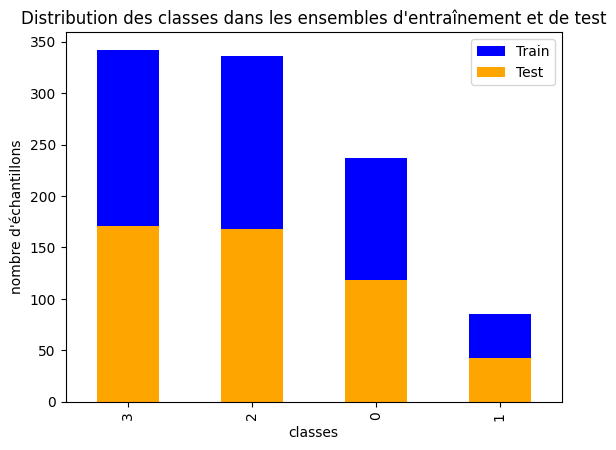

In [12]:
# Exploration des données

## Distribution des classes 
Occurence_train = {}
Occurence_train["classes"] = classes
Occurence_train["occurrences"] = y_train.value_counts()
print(Occurence_train)

y_train.value_counts().plot(kind='bar', color='blue')
y_test.value_counts().plot(kind='bar', color='orange')
plt.xlabel('classes')
plt.ylabel('nombre d\'échantillons')
plt.title('Distribution des classes dans les ensembles d\'entraînement et de test')
plt.legend(['Train','Test'])


Mon premier essai était d'explorer les données et d'essayer de savoir les gènes importantes pour chaque cellule. Le problème c'est que j'ai fait l'exploration sans normalization et jugé que la moitié des gènes ne sont pas assez représentatives pour la majorité des cellules. Les résultats sont dans les diagrammes au-dessous. 
L'idée derrière est aussi le fait d'ajouter des données pour les la classes 1 en se basant sur la distribution de chaque gène dans les cellules détectées cell_1. 

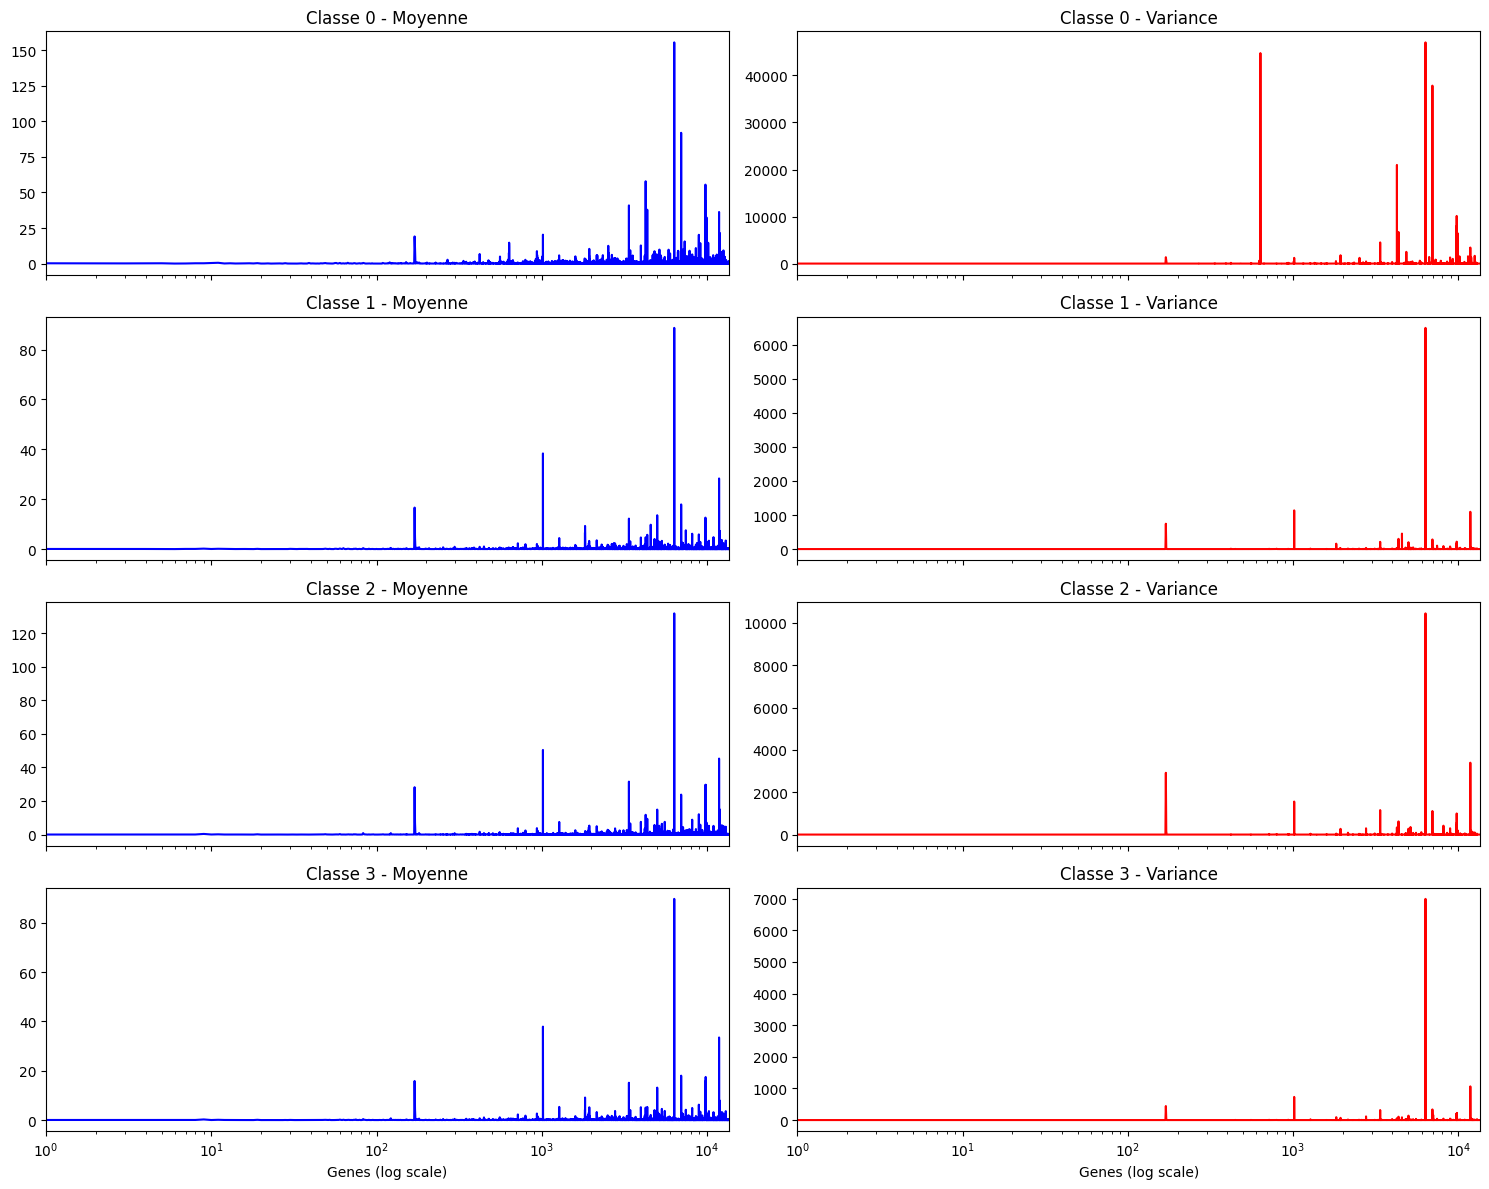

In [11]:
classes = np.unique(y_train)
n_classes = len(classes)
n_genes = X_train.shape[1]

fig, axes = plt.subplots(n_classes, 2, figsize=(15, 3*n_classes), sharex=True)

for idx, cls in enumerate(classes):
    gene_values = X_train[y_train == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convertir sparse -> dense si nécessaire
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    # Moyenne et variance par gène
    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    # Plot moyenne
    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes])

    # Plot variance
    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes])

# Label commun pour l'axe des x
for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()


A partir des digrammes précedants, on remarque qu'environ la moitié  des gènes ( de 0 à 10^2) ne sont pas assez représntatives pour toutes les classes. 
Nous procédons à la suppression des gènes les moins representatifs

In [12]:
import numpy as np
from scipy.sparse import issparse

def remove_genes(X, threshold=0.2):
    """
    Supprime les gènes dont la variance est inférieure à un seuil.

    Args:
        X (np.ndarray ou csr_matrix): matrice cellules x gènes
        threshold (float): seuil minimal de variance

    Returns:
        X_filtered: matrice filtrée (mêmes type que X)
        kept_idx: indices des gènes conservés
    """
    if issparse(X):
        # variance = mean(x^2) - mean(x)^2
        mean = np.array(X.mean(axis=0)).ravel()
        mean_sq = np.array(X.multiply(X).mean(axis=0)).ravel()
        var = mean_sq - mean**2
    else:
        var = X.var(axis=0)

    # indices des gènes à garder
    kept_idx = np.where(var >= threshold)[0]

    # filtrer X
    if issparse(X):
        X_filtered = X[:, kept_idx]
    else:
        X_filtered = X[:, kept_idx]

    return X_filtered, kept_idx
X_train, kept_genes_idx = remove_genes(X_train, threshold=0.01)

**Normalisation**
Maintenant je vais essayer de normaliser les données de x_train et les nommer x_train_normalized.

La question qui se pose: pourquoi appliquer une normalisation ? 
 
 - *Correction de la profondeur de séquençage* : Chaque échantillon peut avoir un nombre total de lectures très différent. Sans normalisation, les différences reflètent surtout la quantité totale de séquençage et non l’expression réelle.
 - *Stabilisation de la variance* : Les gènes peu exprimés ont une variance très élevée relative à leur moyenne. Les gènes très exprimés dominent les analyses multivariées (PCA, clustering).
 - *Comparabilité entre échantillons* : Permet de comparer les niveaux d’expression entre échantillons et conditions.

 


In [13]:
import numpy as np



def preprocess_X(X, method=None):
    """
    Preprocess an RNA-seq expression matrix.
    
    Parameters
    ----------
    X : np.ndarray or scipy.sparse matrix
        Input expression matrix (cells x genes)
    method : str or None
        Type of normalization:
        - None : return X as is
        - "log" : log1p transform
        - "library_size" : normalize each cell by total counts (library size) then log1p
    
    Returns
    -------
    X_processed : np.ndarray
        Preprocessed expression matrix
    """
    # Convert sparse to dense if needed
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    X_processed = X.copy()
    
    if method is None:
        return X_processed
    
    if method == "simple_normalize":
        return X / X.sum(axis=1)[:, np.newaxis]
    
    elif method == "log":
        X_processed = np.log1p(X_processed)
        return X_processed
    
    elif method == "library_size":
        # compute total counts per cell
        library_size = X_processed.sum(axis=1)[:, None]
        # avoid division by zero
        library_size[library_size == 0] = 1
        # normalize
        X_processed = X_processed / library_size * 1e4
        # log1p transform
        X_processed = np.log1p(X_processed)
        return X_processed
    
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

preprocessing_method = "library_size"
X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)


Niveau d'expression des gènes

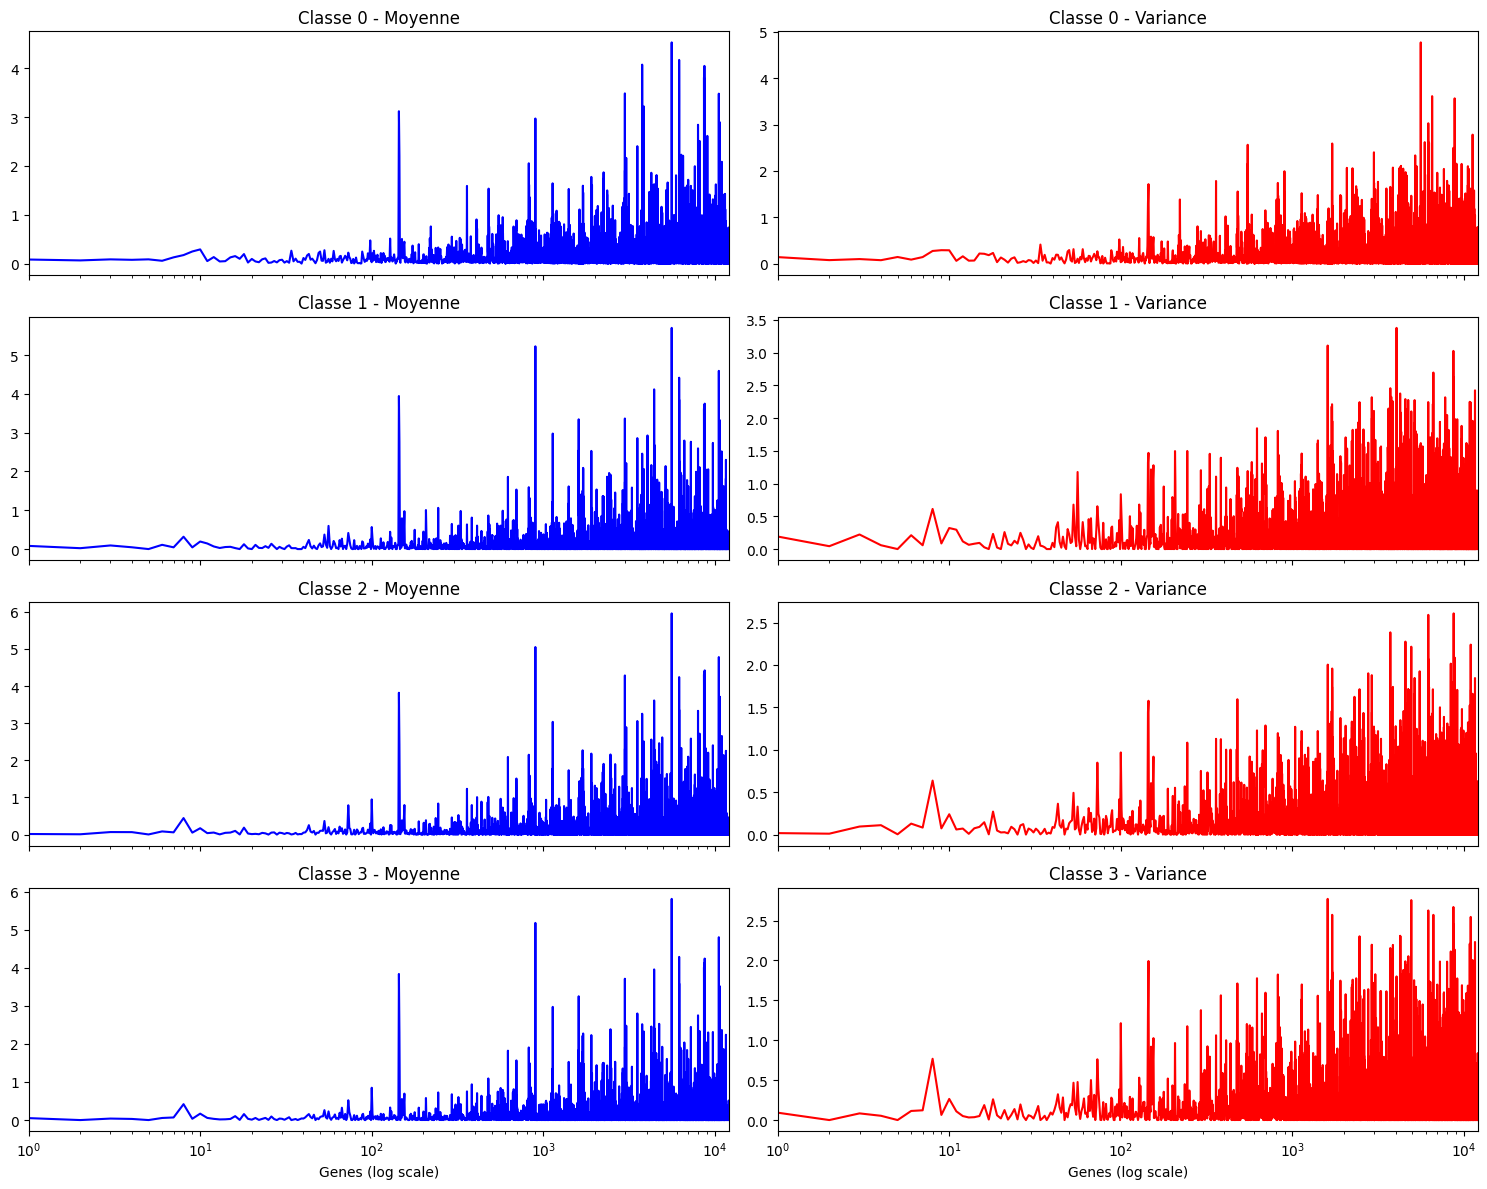

In [14]:
import numpy as np

import matplotlib.pyplot as plt

# Assuming X_train_norm and y_train are available from previous cells
classes = np.unique(y_train)
n_classes = len(classes)
n_genes = X_train_norm.shape[1]

fig, axes = plt.subplots(n_classes, 2, figsize=(15, 3*n_classes), sharex=True)

for idx, cls in enumerate(classes):
    gene_values = X_train_norm[y_train == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convertir sparse -> dense si nécessaire
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    # Moyenne et variance par gène
    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    # Plot moyenne
    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes])

    # Plot variance
    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes])

# Label commun pour l'axe des x
for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()

# ACP

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_scree_plot(X, title_suffix=""):
    """
    Plot the scree plot for PCA on the given data matrix X.
    
    Parameters
    ----------
    X : array-like
        Input data matrix
    title_suffix : str
        Suffix to add to the plot title
    """
    pca = PCA().fit(X)
    explained_variance_cumsum = pca.explained_variance_ratio_.cumsum()
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance_cumsum) + 1), 
             explained_variance_cumsum, marker='o', linestyle='-')
    plt.xlabel('Nombre de composantes principales')
    plt.ylabel('Variance expliquée cumulée')
    plt.title(f'Scree plot (courbe de la variance expliquée){title_suffix}')
    plt.grid(True)
    plt.show()

# Scree plot for raw filtered data
plot_scree_plot(X_train, " - Données brutes filtrées")

# Scree plot for normalized data
plot_scree_plot(X_train_norm, " - Données normalisées")

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

# Implémentation des models


## 1. Light Gradient Boosting

Le light Gradient Boosting est entraîné sur les données normalisées sans application de PCA. En effet, ce choix est justifié par le fait que le GRadient Boosting fait une séléction automatique des variables qui sont plus informatives grâce au split. En plus, LGBM brut, qui est un modèle non linéaire, peut capturer des interactions complexes et non linéaires que l’ACP pourrait diluer. Donc, pas de perte d'informations. 

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

pipe_LGBM = Pipeline([
    
    ("LGBM", LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    objective='multiclass',
    random_state=42,
    n_jobs=-1,
    verbose = -1
))
])

pipe_LGBM 

Pipeline(steps=[('LGBM',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                learning_rate=0.05, n_estimators=500, n_jobs=-1,
                                objective='multiclass', random_state=42,
                                subsample=0.8, verbose=-1))])

In [20]:
lgbm = pipe_LGBM.fit(X_train_norm, y_train)
y_pred_train = lgbm.predict(X_train_norm)
acc_train = balanced_accuracy_score(y_train, y_pred_train)
print("Accuracy score for train dataset :", acc_train)


y_pred_test_lgbm = lgbm.predict(X_test_norm)
acc_test = balanced_accuracy_score(y_test, y_pred_test_lgbm)
print("Accuracy score for test dataset :", acc_test)



Accuracy score for train dataset : 1.0
Accuracy score for test dataset : 0.8293765429537581


Text(0.5, 1.0, 'Confusion matrix of LGBM model on test set')

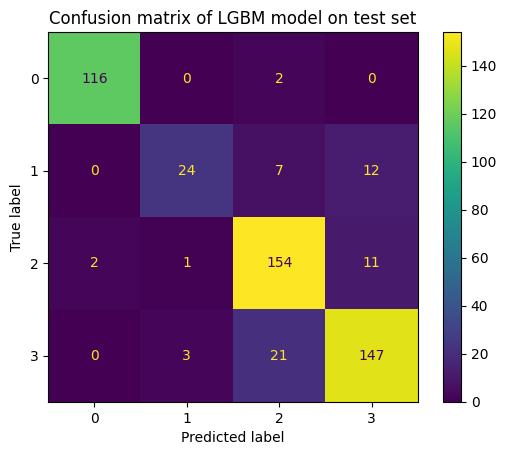

In [22]:
cm_lgbm = confusion_matrix(y_test, y_pred_test_lgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=lgbm.classes_)
disp.plot()
plt.title("Confusion matrix of LGBM model on test set")


<Figure size 800x600 with 0 Axes>

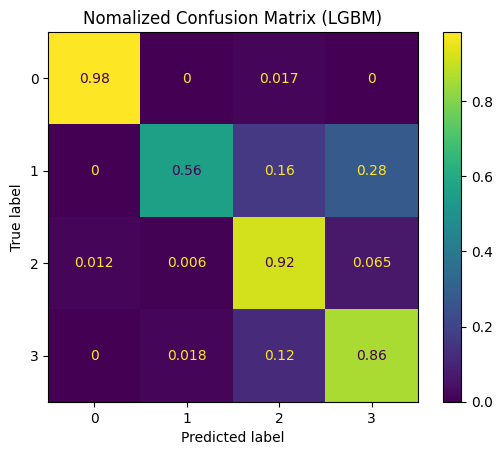

In [23]:
cm_norm = cm_lgbm.astype('float') / cm_lgbm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=lgbm.classes_)
disp_norm.plot()
plt.title('Nomalized Confusion Matrix (LGBM)')
plt.show()

*Validation par Cross Validation*

In [27]:
from sklearn.model_selection import cross_val_score
scores_train = cross_val_score(pipe_LGBM, X_train_norm, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(pipe_LGBM, X_test_norm, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold sur data_train:", scores_train)
print("Accuracy moyenne sur data train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test:", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

Scores CV pour chaque fold sur data_train: [0.86  0.9   0.875 0.905 0.89 ]
Accuracy moyenne sur data train : 0.8859999999999999
Scores CV pour chaque fold sur data_test: [0.84 0.87 0.8  0.87 0.85]
Accuracy moyenne sur data_test : 0.8459999999999999


## 2. Régression logistique

L’utilisation de la régression logistique pour cette tâche de classification des cellules à partir de données scRNA-seq n’est pas nécessairement optimale, étant donné le grand nombre de gènes (variables) et la complexité potentielle des relations non linéaires entre eux. Cependant, elle constitue un excellent point de départ.

**Hétérogénéité des classes** : les effectifs diffèrent entre les classes, ce qui peut entraîner une sous-représentation de certaines d’entre elles et biaiser les modèles de classification => class_weight="balanced" 

**Distribution des valeurs d’expression génique**: les données présentent une grande étendue de valeurs, une forte dispersion ainsi qu’un nombre important de zéros, caractéristiques des données RNA-seq et scRNA-seq. Ces propriétés imposent l’utilisation de méthodes de normalisation et de transformation appropriées afin de réduire le bruit et stabiliser la variance.

**Similarité entre certaines classes** : trois classes présentent des profils d’expression très proches, rendant leur séparation particulièrement difficile. Cette proximité biologique limite l’efficacité des frontières de décision simples et nécessite des approches de sélection de gènes et de modélisation adaptées =>  SelectKBest

**Nombre de gènes** : Un grand nombre de gènes ont une faible expression. Le jeu de données est de haute dimension, ce qui rend l'analyse plus complexe.

In [24]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    confusion_matrix)
 
 
def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
 
    # Log transform
    X = np.log1p(X)
 
    # Library size normalization
    X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
 
    return X
 
 
class Classifier(object):
    def __init__(self):
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(
                score_func=f_classif,
                k=2000  #  à ajuster (1000–5000)
            )),
            ("clf", LogisticRegression(
                penalty="l1",
                solver="saga",
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
 
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        return self
 
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
 
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)
 


===== Fold 1/5 =====


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  249   508   818  1125  1450  1580  1621  1686  2300  2402  2441  3156
  3405  3871  4050  4353  4471  4839  5547  6088  7882  7984  8088  8414
  8763  8822  9659  9693  9720 10241 10391 10541 10823 11225 11359 11417
 11430 11774 11860 12231 12270 12497 13008 13204 13247] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced Accuracy (fold 1): 0.8587

===== Fold 2/5 =====


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  286   515   710   845  1466  1558  1594  2607  2820  2845  3769  3865
  4112  4156  4338  4659  4906  5433  5825  5885  6006  7825  8357  9606
  9630 10125 10139 10918 11371 11608 12177 12764 12768 12819 13099] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced Accuracy (fold 2): 0.8788

===== Fold 3/5 =====


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   33   220   223   611  1016  1442  1606  2431  2433  2511  2594  3024
  3092  3176  3354  4166  4230  4714  5802  6775  7750  7913  8151  8712
  9592  9639  9730  9969 10047 10150 10583 10593 10840 11414 11745 13468] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced Accuracy (fold 3): 0.8055

===== Fold 4/5 =====


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  216   247   621   856  1370  1814  1830  2569  2827  2836  2853  3743
  4066  4361  4668  4671  4788  5286  6194  6717  7133  7476  7756  7969
  9557  9584  9610  9905 10038 10087 10370 11365 12225 12677 12684 12762
 12963 13249 13418] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced Accuracy (fold 4): 0.8531

===== Fold 5/5 =====


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   76  1576  1659  1664  1907  2001  2650  3101  3390  3856  4055  4510
  4513  4996  5174  5392  5607  5895  6053  6055  6098  6156  7975  8034
  8427  9201  9451  9575  9675  9687  9692 11052 11376 11602 11727 11881
 12237 12822 12872 13443] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced Accuracy (fold 5): 0.8570

GLOBAL RESULTS (ALL FOLDS)
Mean Balanced Accuracy: 0.8506136537208391
Std Balanced Accuracy: 0.024259058100717906

Classification Report (global CV):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       237
           1       0.69      0.74      0.72        85
           2       0.86      0.88      0.87       336
           3       0.84      0.81      0.82       342

    accuracy                           0.87      1000
   macro avg       0.84      0.85      0.85      1000
weighted avg       0.87      0.87      0.87      1000



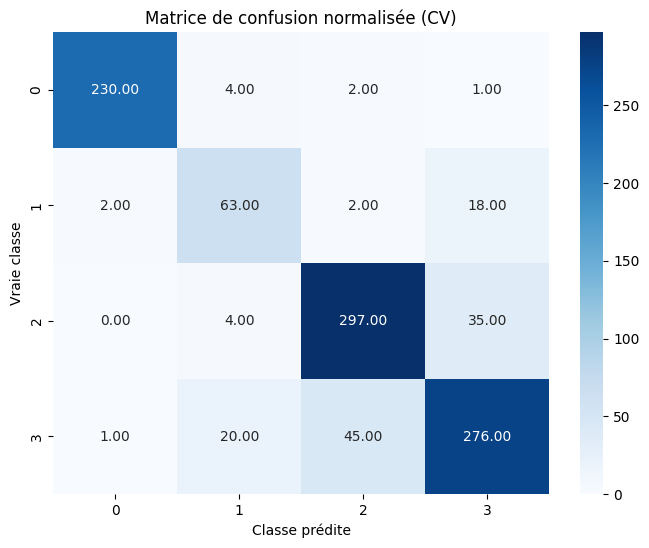


Balanced Accuracy (test set): 0.8266

Classification Report (test set):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       118
           1       0.82      0.65      0.73        43
           2       0.79      0.92      0.85       168
           3       0.86      0.78      0.82       171

    accuracy                           0.86       500
   macro avg       0.87      0.83      0.84       500
weighted avg       0.86      0.86      0.86       500



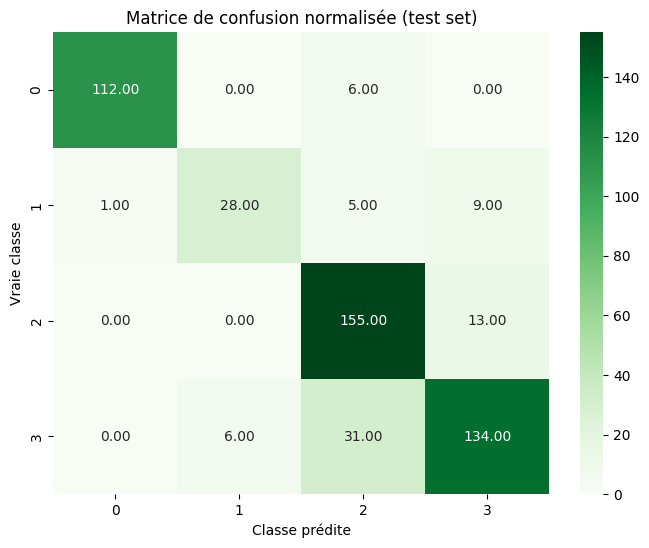

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    confusion_matrix
)

# ======================================================
# 1️⃣ CROSS-VALIDATION + MATRICE DE CONFUSION
# ======================================================
def cross_validate_classifier(X_train, y_train, Classifier, n_splits=5, random_state=42):
    """
    Effectue une cross-validation stratifiée et affiche les résultats globaux.

    Params:
    - X_train, y_train : données et labels d'entraînement
    - Classifier : classe du modèle à entraîner
    - n_splits : nombre de folds
    - random_state : pour reproductibilité
    """
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        clf = Classifier()
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced Accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    # Résultats globaux CV
    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")
    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global CV):")
    print(classification_report(all_y_true, all_y_pred))

    # Matrice de confusion normalisée
    labels = np.unique(y_train)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
   # cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.title('Matrice de confusion normalisée (CV)')
    plt.show()

    return bal_acc_scores

# ======================================================
# 2️⃣ ÉVALUATION SUR LE JEU DE TEST
# ======================================================
def evaluate_on_test(X_train, y_train, X_test, y_test, Classifier):
    """
    Entraîne le modèle sur tout l'entraînement et évalue sur le test.
    """
    clf = Classifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else None

    # Balanced accuracy
    bal_acc_test = balanced_accuracy_score(y_test, y_pred)
    print(f"\nBalanced Accuracy (test set): {bal_acc_test:.4f}")

    # Classification report
    print("\nClassification Report (test set):")
    print(classification_report(y_test, y_pred))

    # Matrice de confusion normalisée
    labels = np.unique(y_test)
    cm_test = confusion_matrix(y_test, y_pred, labels=labels)
    #cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,6))
    sns.heatmap(cm_test, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.title('Matrice de confusion normalisée (test set)')
    plt.show()

    return y_pred, y_proba, bal_acc_test

# ======================================================
# 3️⃣ EXEMPLE D'UTILISATION
# ======================================================
# Balanced accuracy CV
scores_cv = cross_validate_classifier(X_train, y_train, Classifier, n_splits=5)

# Évaluation finale sur le test
y_pred_test, y_proba_test, bal_acc_test = evaluate_on_test(
    X_train, y_train, X_test, y_test, Classifier
)


## 3. Approche: Prédiction en deux etapes

### Adaptation du dataset, merge des classes 1 et 3

Nous entrainons le modèle sur 3 classes.

In [153]:
# Fonctions utiles

def preprocess_X(X, method=None):
    """
    Preprocess an RNA-seq expression matrix.
    
    Parameters
    ----------
    X : np.ndarray or scipy.sparse matrix
        Input expression matrix (cells x genes)
    method : str or None
        Type of normalization:
        - None : return X as is
        - "log" : log1p transform
        - "library_size" : normalize each cell by total counts (library size) then log1p
    
    Returns
    -------
    X_processed : np.ndarray
        Preprocessed expression matrix
    """
    # Convert sparse to dense if needed
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    X_processed = X.copy()
    
    if method is None:
        return X_processed
    
    if method == "simple_normalize":
        return X / X.sum(axis=1)[:, np.newaxis]
    
    elif method == "log":
        X_processed = np.log1p(X_processed)
        return X_processed
    
    elif method == "library_size":
        # compute total counts per cell
        library_size = X_processed.sum(axis=1)[:, None]
        # avoid division by zero
        library_size[library_size == 0] = 1
        # normalize
        X_processed = X_processed / library_size * 1e4
        # log1p transform
        X_processed = np.log1p(X_processed)
        return X_processed
    
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

preprocessing_method = "library_size"




def fit_eval_ensembles(X_train, X_test, y_train, y_test, pca_n_components=60, random_state=42):
    # encode labels to integers for stacking final estimator
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    # PCA reduction
    pca = PCA(n_components=min(pca_n_components, np.asarray(X_train).shape[1]), random_state=random_state)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # base estimators
    rf = RandomForestClassifier(n_estimators=200, max_depth=50, max_features="sqrt", random_state=random_state)
    svc = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=random_state)
    knn = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)



    # Stacking ensemble (uses same base estimators)
    stacking = StackingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
        final_estimator=LogisticRegression(max_iter=2000, solver="lbfgs"),
        n_jobs=-1,
        passthrough=False,
    )

    ensembles = {
        #"Voting (soft)": voting, 
        "Stacking (LR)": stacking}

    results = {}
    for name, clf in ensembles.items():
        print(f"Fitting {name} ...")
        clf.fit(X_train_pca, y_train_enc)
        y_pred_enc = clf.predict(X_test_pca)
        y_pred = le.inverse_transform(y_pred_enc)
        bal = balanced_accuracy_score(y_test, y_pred)
        results[name] = {"bal_acc": bal, "clf": clf, "y_pred": y_pred}
        print(f"{name} balanced accuracy: {bal:.3f}")

        # confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot(cmap="Blues", values_format='d')
        plt.title(f"{name} - Balanced Acc: {bal:.3f}")
        plt.tight_layout()
        plt.show()

    return results, pca, le

In [154]:
#reload the data and preprocess
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [157]:
#normalize the data

X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

X_train_norm_merged = X_train_norm.copy()
X_test_norm_merged = X_test_norm.copy()

# merge classes 1 and 3 (NK_cells and T_cells_CD8+ according to current categories)
merge_from = {"NK_cells", "T_cells_CD8+"}
new_label = "NK_or_T_cells_CD8+"

# convert categorical labels to string arrays and replace
# Use the annotation dict to map codes to names
classes = y_train.categories
annotation = {}
for i, cls in enumerate(classes):
    annotation[i] = cls

y_train_arr = np.array([annotation[code] for code in y_train.codes])
y_test_arr = np.array([annotation[code] for code in y_test.codes])

y_train_merged = y_train_arr.copy()
y_train_merged[np.isin(y_train_merged, list(merge_from))] = new_label

y_test_merged = y_test_arr.copy()
y_test_merged[np.isin(y_test_merged, list(merge_from))] = new_label

# convert back to pandas Categorical (keep behavior similar to original y variables)
y_train_merged = pd.Categorical(y_train_merged)
y_test_merged = pd.Categorical(y_test_merged)

# check
print("Train label distribution:\n", pd.Series(y_train_merged).value_counts())
print("Test label distribution:\n", pd.Series(y_test_merged).value_counts())

Train label distribution:
 NK_or_T_cell    427
T_cells_CD4+    336
Cancer_cells    237
Name: count, dtype: int64
Test label distribution:
 NK_or_T_cell    214
T_cells_CD4+    168
Cancer_cells    118
Name: count, dtype: int64


Filtered X_train_merged shape: (1000, 258)
Filtered X_test_merged shape: (500, 258)
Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.928


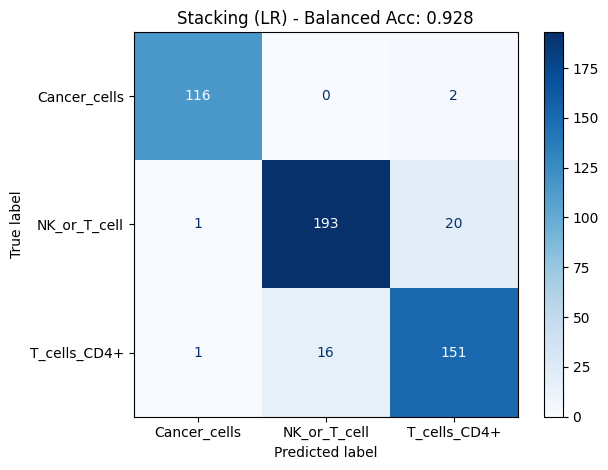

In [158]:
# Filtrage des gènes pour le modèle merged avec threshold=0.2
X_train_merged_filtered, kept_genes_merged_idx = remove_genes(X_train_norm_merged, threshold=1.2)
X_test_merged_filtered = X_test_norm_merged[:, kept_genes_merged_idx]

print(f"Filtered X_train_merged shape: {X_train_merged_filtered.shape}")
print(f"Filtered X_test_merged shape: {X_test_merged_filtered.shape}")

# Entraînement du modèle merged sur les données filtrées
results_merge, pca_model_merge, label_encoder_merge = fit_eval_ensembles(
    X_train_merged_filtered, X_test_merged_filtered, y_train_merged, y_test_merged, pca_n_components=60
)

### Modèle de prediction des classes {"NK_cells", "T_cells_CD8+"}

In [159]:
#reload the data and preprocess
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

#normalize the data

X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

# Create new copies of normalized feature matrices
X_train_norm_binary = X_train_norm.copy()
X_test_norm_binary = X_test_norm.copy()

# Only conserve NK_cells and T_cells_CD8+ in train/test labels
binary_classes = {"NK_cells", "T_cells_CD8+"}

# Convert categorical labels to string arrays
y_train_arr_bin = np.array(y_train).astype(str).copy()
y_test_arr_bin = np.array(y_test).astype(str).copy()

# Filter indices for binary classification
train_idx_bin = np.isin(y_train_arr_bin, list(binary_classes))
test_idx_bin = np.isin(y_test_arr_bin, list(binary_classes))

# Filter features and labels
X_train_norm_bin = X_train_norm_binary[train_idx_bin]
X_test_norm_bin = X_test_norm_binary[test_idx_bin]
y_train_bin = y_train_arr_bin[train_idx_bin]
y_test_bin = y_test_arr_bin[test_idx_bin]

# Convert to pandas Categorical for compatibility
y_train_bin = pd.Categorical(y_train_bin)
y_test_bin = pd.Categorical(y_test_bin)

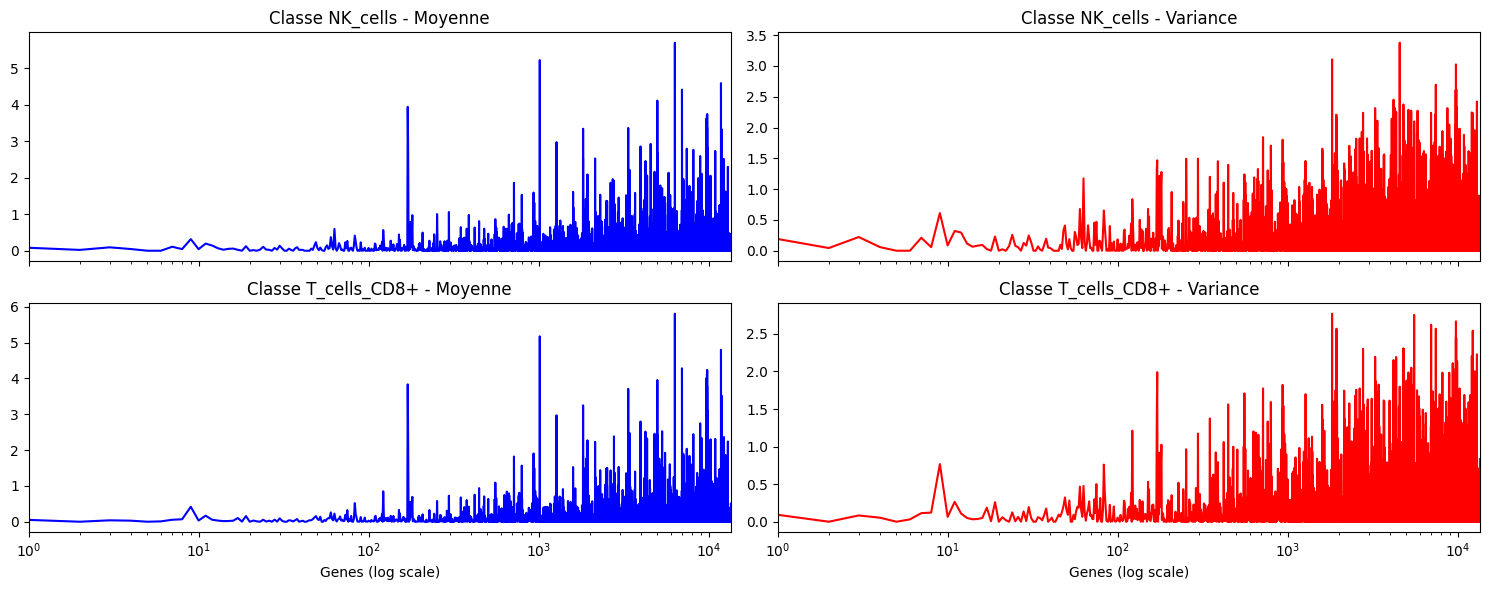

In [160]:
binary_classes = np.unique(y_train_bin)
n_classes_bin = len(binary_classes)
n_genes_bin = X_train_norm_bin.shape[1]

fig, axes = plt.subplots(n_classes_bin, 2, figsize=(15, 3 * n_classes_bin), sharex=True)

for idx, cls in enumerate(binary_classes):
    gene_values = X_train_norm_bin[np.array(y_train_bin) == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convert sparse -> dense if needed
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes_bin])

    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes_bin])

for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()



We keep only high expressed genes

In [161]:
# Remove low expressed genes using variance threshold 0.8

X_train_bin_filtered, kept_genes_bin_idx = remove_genes(X_train_norm_bin, threshold=0.8)
X_test_bin_filtered = X_test_norm_bin[:, kept_genes_bin_idx]

print(f"Filtered X_train_bin shape: {X_train_bin_filtered.shape}")
print(f"Filtered X_test_bin shape: {X_test_bin_filtered.shape}")

Filtered X_train_bin shape: (427, 616)
Filtered X_test_bin shape: (214, 616)


Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.837


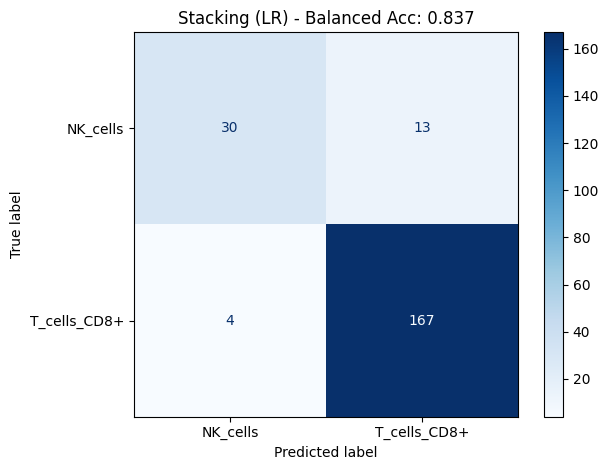

In [162]:

# Train and predict using the previous ensemble function
results_bin, pca_model_bin, label_encoder_bin = fit_eval_ensembles(
    X_train_bin_filtered, X_test_bin_filtered, y_train_bin, y_test_bin, pca_n_components=0.8
)

### Combinaison des deux modèles

In [ ]:
def remove_genes(X, threshold=0.01):
    """
    Supprime les gènes dont la variance est inférieure à un seuil.

    Args:
        X (np.ndarray ou csr_matrix): matrice cellules x gènes
        threshold (float): seuil minimal de variance

    Returns:
        X_filtered: matrice filtrée (mêmes type que X)
        kept_idx: indices des gènes conservés
    """
    if issparse(X):
        # variance = mean(x^2) - mean(x)^2
        mean = np.array(X.mean(axis=0)).ravel()
        mean_sq = np.array(X.multiply(X).mean(axis=0)).ravel()
        var = mean_sq - mean**2
    else:
        var = X.var(axis=0)

    # indices des gènes à garder
    kept_idx = np.where(var >= threshold)[0]

    # filtrer X
    if issparse(X):
        X_filtered = X[:, kept_idx]
    else:
        X_filtered = X[:, kept_idx]

    return X_filtered, kept_idx


class Classifier(object):
    def __init__(self):
        # Label encoders for both stages
        self.le_merge = LabelEncoder()  # For 3-class merged model
        self.le_bin = LabelEncoder()    # For binary NK/T-CD8+ model
        
        # Gene filtering indices
        self.kept_idx_merge = None  # For merged model
        self.kept_idx_bin = None    # For binary model
        
        # Stage 1: Merged model (3 classes: B_cells, Monocytes, NK_or_T_cell)
        rf_merge = RandomForestClassifier(n_estimators=200, max_depth=50,
                                         max_features="sqrt", random_state=42)
        svc_merge = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale",
                       random_state=42)
        knn_merge = KNeighborsClassifier(n_neighbors=15)
        
        stack_merge = StackingClassifier(
            estimators=[("rf", rf_merge), ("svc", svc_merge), ("knn", knn_merge)],
            final_estimator=LogisticRegression(max_iter=10000, solver="lbfgs"),
            n_jobs=-1,
            passthrough=False
        )
        
        self.pipe_merge = make_pipeline(
            PCA(n_components=60, random_state=42),
            stack_merge
        )
        
        # Stage 2: Binary model (NK_cells vs T_cells_CD8+)
        rf_bin = RandomForestClassifier(n_estimators=200, max_depth=50,
                                       max_features="sqrt", random_state=42)
        svc_bin = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale",
                     random_state=42)
        knn_bin = KNeighborsClassifier(n_neighbors=15)
        
        stack_bin = StackingClassifier(
            estimators=[("rf", rf_bin), ("svc", svc_bin), ("knn", knn_bin)],
            final_estimator=LogisticRegression(max_iter=10000, solver="lbfgs"),
            n_jobs=-1,
            passthrough=False
        )
        
        self.pipe_bin = make_pipeline(
            PCA(n_components=0.8, random_state=42),  # 80% variance
            stack_bin
        )

    def _preprocess_X(self, X, fit=False, kept_idx=None, threshold=0.01):
        """
        Preprocess features: filter genes + library size normalization + log1p
        """
        # Convert sparse to dense if needed
        if issparse(X):
            X = X.toarray()
        
        # Gene filtering
        if fit:
            X_filtered, kept_idx = remove_genes(X, threshold=threshold)
            return_idx = kept_idx
        else:
            if kept_idx is None:
                raise ValueError("kept_idx must be provided when fit=False")
            X_filtered = X[:, kept_idx]
            return_idx = None
        
        # Library size normalization + log1p
        libsize = X_filtered.sum(axis=1)[:, None]
        libsize[libsize == 0] = 1
        X_processed = np.log1p(X_filtered / libsize * 1e4)
        
        if fit:
            return X_processed, return_idx
        else:
            return X_processed

    def fit(self, X_sparse, y):
        """
        Train the two-stage classifier
        
        Stage 1: Train merged model (3 classes)
        Stage 2: Train binary model (NK_cells vs T_cells_CD8+)
        """
        # Convert y to numpy array
        y_arr = np.array(y).astype(str)
        
        # ===== STAGE 1: Merged Model (3 classes) =====
        # Merge NK_cells and T_cells_CD8+ into one class
        merge_from = {"NK_cells", "T_cells_CD8+"}
        self.merged_label = "NK_or_T_cell"  # Store the merged label name
        
        y_merged = y_arr.copy()
        y_merged[np.isin(y_merged, list(merge_from))] = self.merged_label
        
        # Preprocess and fit merged model
        X_merge, self.kept_idx_merge = self._preprocess_X(X_sparse, fit=True, threshold=1.2)
        y_merge_enc = self.le_merge.fit_transform(y_merged)
        self.pipe_merge.fit(X_merge, y_merge_enc)
        
        # ===== STAGE 2: Binary Model (NK_cells vs T_cells_CD8+) =====
        # Filter to only NK_cells and T_cells_CD8+
        binary_classes = {"NK_cells", "T_cells_CD8+"}
        bin_mask = np.isin(y_arr, list(binary_classes))
        
        X_bin = X_sparse[bin_mask] if issparse(X_sparse) else X_sparse[bin_mask]
        y_bin = y_arr[bin_mask]
        
        # Preprocess with higher variance threshold for binary model
        X_bin_processed, self.kept_idx_bin = self._preprocess_X(X_bin, fit=True, threshold=0.8)
        y_bin_enc = self.le_bin.fit_transform(y_bin)
        self.pipe_bin.fit(X_bin_processed, y_bin_enc)
        
        # Store original classes for compatibility
        self.classes_ = np.unique(y_arr)
        
        # Create mapping from class names to indices
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes_)}

    def predict_proba(self, X_sparse):
        """
        Two-stage prediction:
        1. Predict with merged model (3 classes)
        2. If predicted as NK_or_T_cell, refine with binary model
        """
        n_samples = X_sparse.shape[0]
        n_classes = len(self.classes_)
        
        # Initialize probability matrix
        proba_final = np.zeros((n_samples, n_classes))
        
        # ===== STAGE 1: Predict with merged model =====
        X_merge = self._preprocess_X(X_sparse, fit=False, kept_idx=self.kept_idx_merge)
        proba_merge = self.pipe_merge.predict_proba(X_merge)
        y_pred_merge_enc = self.pipe_merge.predict(X_merge)
        y_pred_merge = self.le_merge.inverse_transform(y_pred_merge_enc)
        
        # ===== STAGE 2: Process predictions =====
        nk_or_t_mask = y_pred_merge == self.merged_label
        
        # For samples NOT predicted as merged class
        for i in np.where(~nk_or_t_mask)[0]:
            pred_label = y_pred_merge[i]
            class_idx = self.class_to_idx[pred_label]
            # Use probabilities from merged model
            merge_class_idx = self.le_merge.transform([pred_label])[0]
            proba_final[i, class_idx] = proba_merge[i, merge_class_idx]
        
        # For samples predicted as merged class, refine with binary model
        if nk_or_t_mask.sum() > 0:
            # Get samples predicted as merged class
            X_bin = X_sparse[nk_or_t_mask] if issparse(X_sparse) else X_sparse[nk_or_t_mask]
            
            # Preprocess with binary model's gene filtering
            X_bin_processed = self._preprocess_X(X_bin, fit=False, kept_idx=self.kept_idx_bin)
            
            # Predict with binary model
            proba_bin = self.pipe_bin.predict_proba(X_bin_processed)
            
            # Map binary probabilities to final matrix
            bin_classes = self.le_bin.classes_
            nk_or_t_indices = np.where(nk_or_t_mask)[0]
            
            for j, sample_idx in enumerate(nk_or_t_indices):
                for k, bin_class in enumerate(bin_classes):
                    class_idx = self.class_to_idx[bin_class]
                    proba_final[sample_idx, class_idx] = proba_bin[j, k]
        
        return proba_final

Below is a simplified version of what RAMP does with your submission.

In [137]:
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()
clf = Classifier()
clf.fit(X_train, y_train)
# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

In [138]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.9587611799105606
Test balanced accuracy: 0.8439568899913691


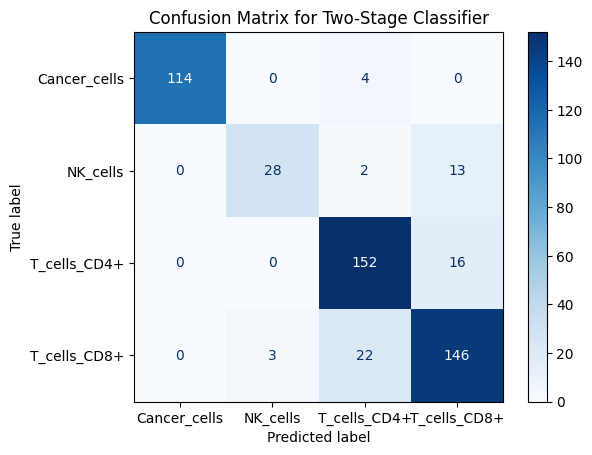

In [142]:
# Confusion matrix for the two-stage classifier
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix for Two-Stage Classifier")
plt.show()

# Approche: Prediction en 3 étapes

Ayant obtenu de bons résultats avec la régression logistique (balanced accuracy de 0.84 sur RAMP), ce modèle sera utilisé pour la classification des cellules cancéreuses versus les autres.
Ensuite, la classification des cellules NK versus les autres sera réalisée à l’aide d’un Gradient Boosting Machine (LGBMClassifier). Étant donné que cette classe est sous-représentée, l’utilisation de class_weight='balanced' et de scale_pos_weight=678 / 85 permet de donner plus d’importance à cette classe lors de l’apprentissage. De plus, les paramètres de régularisation reg_alpha=0.7 et reg_lambda=0.3 contribuent à réduire le surapprentissage.
Enfin, un SVM linéaire sera utilisé pour la classification des cellules CD4 versus CD8.

La classe RNAseqPreprocessor effectue plusieurs étapes de retraitement des données scRNA-seq pour préparer les données à la classification :

**Normalisation par cellule (normalize_total)** : Cela permet de corriger les différences de profondeur de séquençage entre cellules et de rendre les gènes comparables.

**Transformation logarithmique (log1p)** : après normalisation, les valeurs sont transformées par log(1 + x). Cette étape réduit l’influence des gènes très fortement exprimés et stabilise la variance, ce qui améliore la performance des modèles de classification.

**Sélection des gènes les plus variables (highly_variable_genes)** : parmi tous les gènes, seuls les n_top_genes présentant la plus grande variabilité entre cellules sont conservés. Cela permet de réduire la dimensionnalité et de concentrer le modèle sur les gènes les plus informatifs pour distinguer les types cellulaires.

In [12]:
import numpy as np
import scanpy as sc
 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.svm import SVC
 
 
# ======================================================
# RNA-seq Preprocessor
# ======================================================
class RNAseqPreprocessor:
    def __init__(self, n_top_genes=5000):
        self.n_top_genes = n_top_genes
        self.var_genes_idx = None
 
    def fit(self, X, y=None):
        X = X.toarray() if hasattr(X, "toarray") else X
        adata = sc.AnnData(X)
 
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
 
        sc.pp.highly_variable_genes(
            adata, n_top_genes=self.n_top_genes
        )
        self.var_genes_idx = np.where(adata.var["highly_variable"])[0]
        return self
 
    def transform(self, X):
        X = X.toarray() if hasattr(X, "toarray") else X
        adata = sc.AnnData(X)
 
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        
 
        return adata[:, self.var_genes_idx].X
 
 
# ======================================================
# Hierarchical Classifier (avec Pipelines)
# ======================================================
class Classifier:
    def __init__(self, n_top_genes=5000):
        self.preprocessor = RNAseqPreprocessor(n_top_genes)
 
        # 1️⃣ Cancer vs Autres
        self.cancer_detector = Pipeline([
            ("clf", LogisticRegression(
                class_weight="balanced",
                max_iter=2000,
                solver="lbfgs",
                multi_class="auto"
            ))
        ])
 
 
        self.nk_t_detector = Pipeline([ 
            ("lgb",lgb.LGBMClassifier(
                n_estimators=2000,
                learning_rate=0.05,
                max_depth=5,
                class_weight='balanced',   
                reg_alpha=0.7,
                reg_lambda=0.3,
                scale_pos_weight=678 / 85,
                random_state=42,
                verbose=-1,
                n_jobs=-1
            ))
        ])
 
 

 
        # 3️⃣ CD4 vs CD8
        self.cd4_cd8_detector = Pipeline([
            ("svc", SVC(
                kernel='linear',               
                C=1.0,                         
                class_weight='balanced',       
                random_state=42,               
                probability=True,              
                max_iter=2000                  
            ))
        ])
 
        # flags sécurité CV
        self.has_nk_t = False
        self.has_cd4_cd8 = False
 
    # ==================================================
    def fit(self, X_sparse, y):
        X = self.preprocessor.fit(X_sparse, y).transform(X_sparse)
        y = np.array(y)
 
        # -------- 1️⃣ Cancer vs Autres
        is_cancer = (y == "Cancer_cells")
        self.cancer_detector.fit(X, is_cancer)
 
        # -------- Autres cellules
        X_other = X[~is_cancer]
        y_other = y[~is_cancer]
 
        # -------- 2️⃣ NK vs T
        mask_nk = (y_other == "NK_cells")
        mask_t = np.isin(y_other, ["T_cells_CD4+", "T_cells_CD8+"])
 
        X_nk_t = X_other[mask_nk | mask_t]
        y_nk_t = mask_nk[mask_nk | mask_t]  # NK=True, T=False
 
        if len(np.unique(y_nk_t)) == 2:
            self.nk_t_detector.fit(X_nk_t, y_nk_t)
            self.has_nk_t = True
        else:
            self.has_nk_t = False
 
        # -------- 3️⃣ CD4 vs CD8
        X_t = X_other[mask_t]
        y_t = y_other[mask_t]
 
        y_cd4 = (y_t == "T_cells_CD4+")
 
        if len(np.unique(y_cd4)) == 2:
            self.cd4_cd8_detector.fit(X_t, y_cd4)
            self.has_cd4_cd8 = True
        else:
            self.has_cd4_cd8 = False
 
        return self
 
    # ==================================================
    def predict(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        preds = []
 
        is_cancer = self.cancer_detector.predict(X)
 
        for i, cancer in enumerate(is_cancer):
            if cancer:
                preds.append("Cancer_cells")
                continue
 
            # NK vs T
            if self.has_nk_t:
                is_nk = self.nk_t_detector.predict(X[i].reshape(1, -1))[0]
            else:
                is_nk = False
 
            if is_nk:
                preds.append("NK_cells")
                continue
 
            # CD4 vs CD8
            if self.has_cd4_cd8:
                is_cd4 = self.cd4_cd8_detector.predict(X[i].reshape(1, -1))[0]
                preds.append("T_cells_CD4+" if is_cd4 else "T_cells_CD8+")
            else:
                preds.append("T_cells_CD4+")
 
        return np.array(preds)
    
 
    def predict_proba(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        n = X.shape[0]
 
    # Ordre FIXE des classes
        classes = [
            "Cancer_cells",
            "NK_cells",
            "T_cells_CD4+",
            "T_cells_CD8+"
        ]
 
        proba = np.zeros((n, len(classes)))
 
    # =========================
    # 1️⃣ Cancer vs Autres
    # =========================
        p_cancer = self.cancer_detector.predict_proba(X)[:, 1]
        p_other = 1.0 - p_cancer
 
    # =========================
    # 2️⃣ NK vs T
    # =========================
        if self.has_nk_t:
            p_nk = self.nk_t_detector.predict_proba(X)[:, 1]
            p_t = 1.0 - p_nk
        else:
        # fallback CV
            p_nk = np.zeros(n)
            p_t = np.ones(n)
 
    # =========================
    # 3️⃣ CD4 vs CD8
    # =========================
        if self.has_cd4_cd8:
            p_cd4 = self.cd4_cd8_detector.predict_proba(X)[:, 1]
            p_cd8 = 1.0 - p_cd4
        else:
        # fallback CV
            p_cd4 = np.ones(n)
            p_cd8 = np.zeros(n)
 
    # =========================
    # 🔗 Combinaison hiérarchique
    # =========================
        proba[:, 0] = p_cancer
        proba[:, 1] = p_other * p_nk
        proba[:, 2] = p_other * p_t * p_cd4
        proba[:, 3] = p_other * p_t * p_cd8
 
        return proba


===== Fold 1/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Balanced Accuracy (fold 1): 0.8676

===== Fold 2/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Balanced Accuracy (fold 2): 0.8936

===== Fold 3/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Balanced Accuracy (fold 3): 0.8389

===== Fold 4/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Balanced Accuracy (fold 4): 0.8729

===== Fold 5/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Balanced Accuracy (fold 5): 0.8747

GLOBAL RESULTS (ALL FOLDS)
Mean Balanced Accuracy: 0.8695592927307197
Std Balanced Accuracy: 0.017681989696159372

Classification Report (global CV):
              precision    recall  f1-score   support

Cancer_cells       1.00      1.00      1.00       237
    NK_cells       0.68      0.78      0.73        85
T_cells_CD4+       0.88      0.91      0.89       336
T_cells_CD8+       0.86      0.80      0.83       342

    accuracy                           0.88      1000
   macro avg       0.85      0.87      0.86      1000
weighted avg       0.88      0.88      0.88      1000



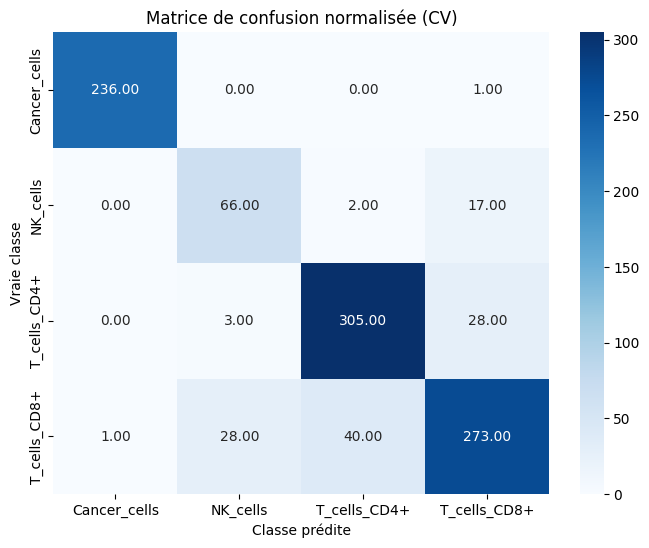

/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Balanced Accuracy (test set): 0.8388

Classification Report (test set):
              precision    recall  f1-score   support

Cancer_cells       1.00      0.97      0.99       118
    NK_cells       0.76      0.65      0.70        43
T_cells_CD4+       0.82      0.92      0.87       168
T_cells_CD8+       0.86      0.81      0.84       171

    accuracy                           0.87       500
   macro avg       0.86      0.84      0.85       500
weighted avg       0.87      0.87      0.87       500



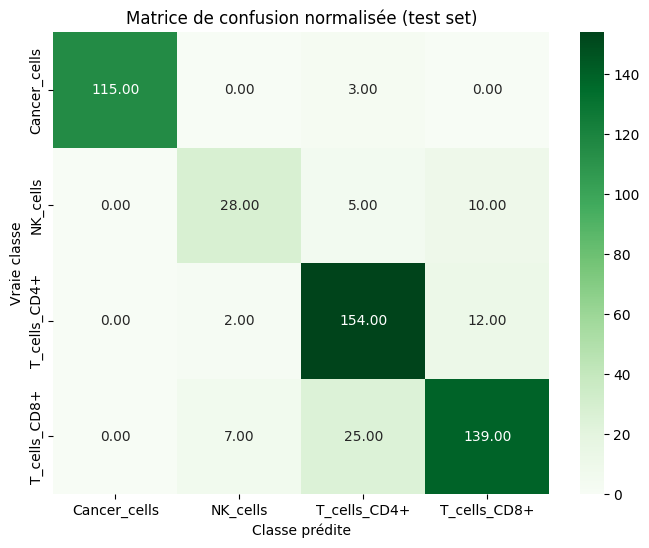

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    confusion_matrix
)

# ======================================================
# 1️⃣ CROSS-VALIDATION + MATRICE DE CONFUSION
# ======================================================
def cross_validate_classifier(X_train, y_train, Classifier, n_splits=5, random_state=42):
    """
    Effectue une cross-validation stratifiée et affiche les résultats globaux.

    Params:
    - X_train, y_train : données et labels d'entraînement
    - Classifier : classe du modèle à entraîner
    - n_splits : nombre de folds
    - random_state : pour reproductibilité
    """
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        clf = Classifier()
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced Accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    # Résultats globaux CV
    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")
    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global CV):")
    print(classification_report(all_y_true, all_y_pred))

    # Matrice de confusion normalisée
    labels = np.unique(y_train)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
   # cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.title('Matrice de confusion normalisée (CV)')
    plt.show()

    return bal_acc_scores

# ======================================================
# 2️⃣ ÉVALUATION SUR LE JEU DE TEST
# ======================================================
def evaluate_on_test(X_train, y_train, X_test, y_test, Classifier):
    """
    Entraîne le modèle sur tout l'entraînement et évalue sur le test.
    """
    clf = Classifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else None

    # Balanced accuracy
    bal_acc_test = balanced_accuracy_score(y_test, y_pred)
    print(f"\nBalanced Accuracy (test set): {bal_acc_test:.4f}")

    # Classification report
    print("\nClassification Report (test set):")
    print(classification_report(y_test, y_pred))

    # Matrice de confusion normalisée
    labels = np.unique(y_test)
    cm_test = confusion_matrix(y_test, y_pred, labels=labels)
    #cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,6))
    sns.heatmap(cm_test, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.title('Matrice de confusion normalisée (test set)')
    plt.show()

    return y_pred, y_proba, bal_acc_test

# ======================================================
# 3️⃣ EXEMPLE D'UTILISATION
# ======================================================
# Balanced accuracy CV
scores_cv = cross_validate_classifier(X_train, y_train, Classifier, n_splits=5)

# Évaluation finale sur le test
y_pred_test, y_proba_test, bal_acc_test = evaluate_on_test(
    X_train, y_train, X_test, y_test, Classifier
)


# Test

In [164]:
!ramp-test --submission test

Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/test ...
CV fold 0
	score  bal_acc       time
	train     0.96  12.263047
	valid     0.85   0.548129
	test      0.81   0.161806
CV fold 1
	score  bal_acc      time
	train     0.97  8.597806
	valid     0.86  0.360050
	test      0.83  0.276123
CV fold 2
	score  bal_acc      time
	train     0.95  7.774569
	valid     0.88  0.257067
	test      0.82  0.154975
CV fold 3
	score  bal_acc      time
	train     0.95  7.992068
	valid     0.86  0.389860
	test      0.82  0.267249
CV fold 4
	score  bal_acc      time
	train     0.97  8.218049
	valid     0.87  0.353038
	test      0.84  0.218822
----------------------------
Mean CV scores
----------------------------
	score       bal_acc        time
	train  0.96 ± 0.009  9.0 ± 1.67
	valid   0.86 ± 0.01  0.4 ± 0.09
	test   0.82 ± 0.012  0.2 ± 0.05
----------------------------
Bagged scores
----------------------------
	sco